In [1]:
from datetime import timedelta,date 
import numpy as np
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt
import time
import pandas as pd

from sklearn.linear_model import LinearRegression

from objectes import SupportVSResistanced, Indicators

df = pd.read_csv('XAUUSD_D1.csv')

INDEX_START = 1650
INDEX_END = 120 + INDEX_START
N_BEFORE = 2
N_AFTER = 2
TICKER_NAME = 'XAUUSD'
df_true = df[INDEX_START-20:INDEX_END+50]
df = df[INDEX_START:INDEX_END]
df.index = [i for i in range(len(df))]  

# Use this algoritm that i create in objects python file
algoritm = SupportVSResistanced(df)
indi = Indicators(df["open"], df["low"], df["high"], df["close"])

df.head()

,time,open,high,low,close,volume
0,2012-04-11 00:00,1654.883,1662.517,1652.848,1658.157,1380
1,2012-04-12 00:00,1658.175,1680.013,1650.452,1674.540,1381
2,2012-04-13 00:00,1674.560,1677.856,1649.248,1657.764,1049
3,2012-04-15 00:00,1654.022,1655.306,1649.206,1651.212,330
4,2012-04-16 00:00,1651.186,1657.747,1641.152,1649.635,1381


In [2]:
# Get Up highes and Down Lowesr data
def GetLevels():
    levels_up = []
    levels_down = []
    for index in range(N_BEFORE, len(df)-N_AFTER):
        if algoritm.support(index, N_BEFORE, N_AFTER):
            l = df["low"].iloc[index]
            levels_down.append([index, df["low"].iloc[index]])
        elif algoritm.resistance(index, N_BEFORE, N_AFTER):
            l = df["high"].iloc[index]
            levels_up.append([index, df["high"].iloc[index]])  

    return levels_up, levels_down

levels_up, levels_down = GetLevels()
('Up', levels_up), ('Down', levels_down)

(('Up',
  [[17, 1671.502],
   [40, 1583.944],
   [48, 1640.943],
   [59, 1633.173],
   [64, 1588.285],
   [77, 1601.183],
   [92, 1629.483]]),
 ('Down',
  [[30, 1526.925],
   [36, 1533.294],
   [67, 1548.0],
   [97, 1584.553],
   [108, 1589.922]]))

In [3]:
# removing Noises
def FilterLength(lvl, type_lines='up'): # up or down
    try:
        for l in range(len(lvl)):
            if lvl[l+1][0]-lvl[l][0]<=9:
                if type_lines=='up':
                    minimom = min(lvl[l+1][1], lvl[l+1][1])
                    if lvl[l+1][1]==minimom:
                        print('removed')
                        lvl.remove(lvl[l+1])
                    else:
                        print('removed')
                        lvl.remove(lvl[l])

                else:
                    minimom = max(lvl[l+1][1], lvl[l+1][1])
                    if lvl[l+1][1]==minimom:
                        print('removed')
                        lvl.remove(lvl[l+1])
                    else:
                        print('removed')
                        lvl.remove(lvl[l])
            else:
                if type_lines=='up':
                    if lvl[l+1][1]>lvl[l][1]:
                        print('removed')
                        lvl.remove(lvl[l])
                else:   
                    if lvl[l+1][1]<lvl[l][1]:
                        print('removed')
                        lvl.remove(lvl[l])

            if l==len(lvl)-2:
                break
                
    except Exception as e:
        try:
            for l in range(len(lvl)):
                if lvl[l+1][0]-lvl[l][0]<=9:
                    if type_lines=='up':
                        minimom = min(lvl[l+1][1], lvl[l+1][1])
                        if lvl[l+1][1]==minimom:
                            print('removed')
                            lvl.remove(lvl[l+1])
                        else:
                            print('removed')
                            lvl.remove(lvl[l])
                        
                    else:
                        minimom = max(lvl[l+1][1], lvl[l+1][1])
                        if lvl[l+1][1]==minimom:
                            print('removed')
                            lvl.remove(lvl[l+1])
                        else:
                            lvl.remove(lvl[l])
                else:
                    if type_lines=='up':
                        if lvl[l+1][1]>lvl[l][1]:
                            print('removed')
                            lvl.remove(lvl[l])
                    else:
                        if lvl[l+1][1]<lvl[l][1]:
                            print('removed')
                            lvl.remove(lvl[l])

                if l==len(lvl)-2:
                    break
                    
        except Exception as e:
            print(e)

    
    try:                 
        if type_lines=='up':
            if lvl[l+1][0]-lvl[l][0]<=9:
                minimom = min(lvl[l+1][1], lvl[l+1][1])
                if lvl[l+1][1]==minimom:
                    print('removed')
                    lvl.remove(lvl[l+1])
                else:
                    print('removed')
                    lvl.remove(lvl[l])              
                
            elif lvl[-1][1]>lvl[-2][1]:
                print('removed')
                lvl.remove(lvl[-2])
        else:
            if lvl[l+1][0]-lvl[l][0]<=9:
                maximom = max(lvl[l+1][1], lvl[l+1][1])
                if lvl[l+1][1]==maximom:
                    print('removed')
                    lvl.remove(lvl[l+1])
                else:
                    print('removed')
                    lvl.remove(lvl[l])
                
            elif lvl[-1][1]<lvl[-2][1]:
                print('removed')
                lvl.remove(lvl[-2])
    except Exception as e:
        print(e)
            
    return lvl
            

print('start remove noise')
# remove noises with this function that i create
levels_up = FilterLength(levels_up, type_lines='up')
levels_down = FilterLength(levels_down, type_lines='down')

# Tow times must chekced to remove noises
levels_up = FilterLength(levels_up, type_lines='up')
levels_down = FilterLength(levels_down, type_lines='down')



start remove noise
removed
removed
removed
removed
removed


In [4]:
# Create the Model and do preprocessing and predict the values
model = LinearRegression()
def PreprocessingData(lvl):
    if len(lvl)>1:
        x = []
        y = []
        for value in lvl:
            x.append(value[0])
            y.append(value[1])

        x, y = np.array(x).reshape(-1, 1), np.array(y)
        x_forcast = []
        for i in range(x[0][0], df.index[-1]):
            x_forcast.append(i)
        x_forcast = np.array(x_forcast).reshape(-1, 1)

        model.fit(x, y)
        y_pred = model.predict(x_forcast)

        return y_pred, x_forcast, model.coef_
    
    else:
        return None, None, None


In [5]:
# Put data in model regression  
pred_up, x_up, slope_up = PreprocessingData(levels_up)
pred_down, x_down, slope_down = PreprocessingData(levels_down)

# check the model fit well and don't return None value
# and check the slot must be negetive and positive 
if pred_down is not None and pred_up is not None:
    if slope_up>0 and slope_down>0 or slope_up<0 and slope_down<0:
        pred_up, x_up = None, None
        pred_down, x_down = None, None

In [6]:
# get slop negetive and positive
slope_up, slope_down

(array([-0.57596285]), array([0.84874816]))

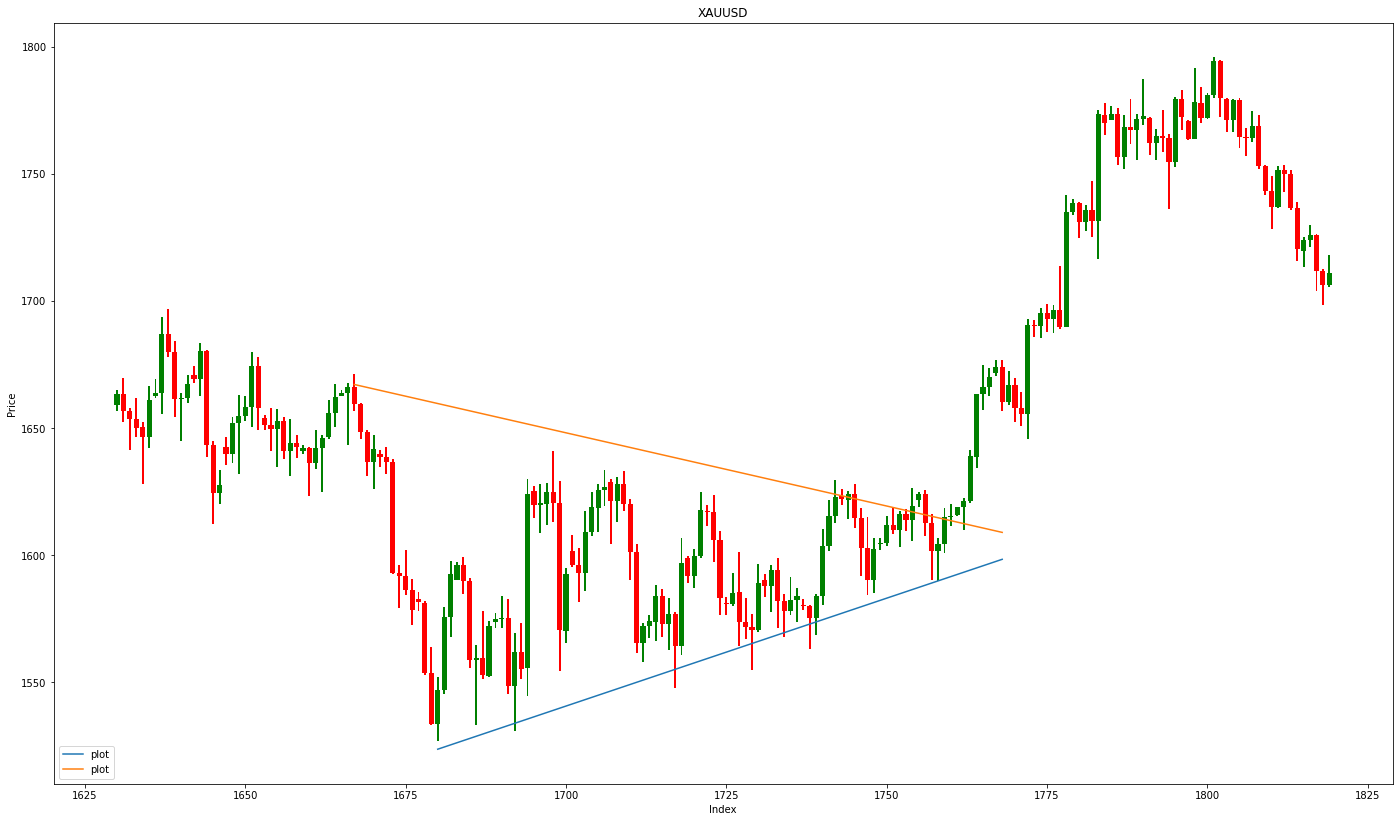

In [7]:
# show the result
def chandlesPlot(d, o, h, l, c):
    plt.figure(figsize=(24, 14))
    color = []
    for open_p, close_p in zip(o, c):
        if open_p<close_p:
            color.append("g")
        else:
            color.append("r")

    plt.bar(d, height=np.abs(o-c), 
            width=0.8, 
            color=color, 
            bottom=np.min((o, c), axis=0))
    plt.bar(d, height=h-l, width=0.3, color=color, bottom=l)
    

def Visulasation():
    chandlesPlot(df_true.index, df_true["open"], 
                 df_true["high"], df_true["low"], 
                 df_true["close"])

    if pred_down is not None and pred_up is not None:     
        plt.plot(x_down+INDEX_START, pred_down, label='plot')
        plt.plot(x_up+INDEX_START, pred_up, label='plot')
        
    plt.title(TICKER_NAME)
    plt.xlabel("Index")
    plt.ylabel("Price")
    plt.legend(loc="lower left")  
    #plt.savefig(f"test_pictures_1/{episode}.jpg")
    plt.show()



Visulasation()